# Style Transfer Implementation

## Purpose

The purpose of this notebook is to implement style transfer in PyTorch using a neural network pretrained on the VGG19 model.

Style transfer is the task of taking two images, a "content image" and a "style image", and generating a new photo ("target image") that uses the content from the "content image" and the style from the "style image".

## Imports and Installations

In [0]:
! pip install torch torchvision
! pip install tqdm

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%matplotlib inline

import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## Building the Model (transfer learning from the VGG19 model)

In [0]:
vgg = models.vgg19(pretrained=True).features # we are importing the "features" portion (the CNN portion designed for extracting features from images) from the pretrained (on ImageNet) VGG19 model

for param in vgg.parameters(): # this freezes the vgg portion of the network (by making requires_gradient = False) so it is not changed during training
  param.requires_grad_(False)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device) # note that in the following output, the fully connected layers are not present in our model architecture since we only imported the "features" portion of the VGG19 model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Loading the Images

In [0]:
def load_image(img_path, max_size=400, shape=None):

  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape  
  
  in_transform = transforms.Compose([
                      transforms.Resize(size), # note that this function maintains the aspect ratio. So, the size set is for the small edge, but the bigger edge can be bigger than the max_value depending on the aspect ratio
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5),
                                           (0.5, 0.5, 0.5))
  ])
  image = in_transform(image).unsqueeze(0)
  return image

In [0]:
content = load_image('drive/My Drive/ML Colab/City.jpg').to(device)
style = load_image('drive/My Drive/ML Colab/StarryNight.jpg', shape=content.shape[-2:]).to(device) # we pass a shape arguement in this call so that the content image and style image are the same dimensions (which is better when doing a style transfer task). Also we use shape[-2:] to access the elements in the tensor that correspond to the dimensions if the image

In [0]:
def im_convert(tensor): # this function is used to convert the tensor image back to numpy (and reverse all transformations done earlier) so it is compatible with matplotlib
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image


(-0.5, 599.5, 399.5, -0.5)

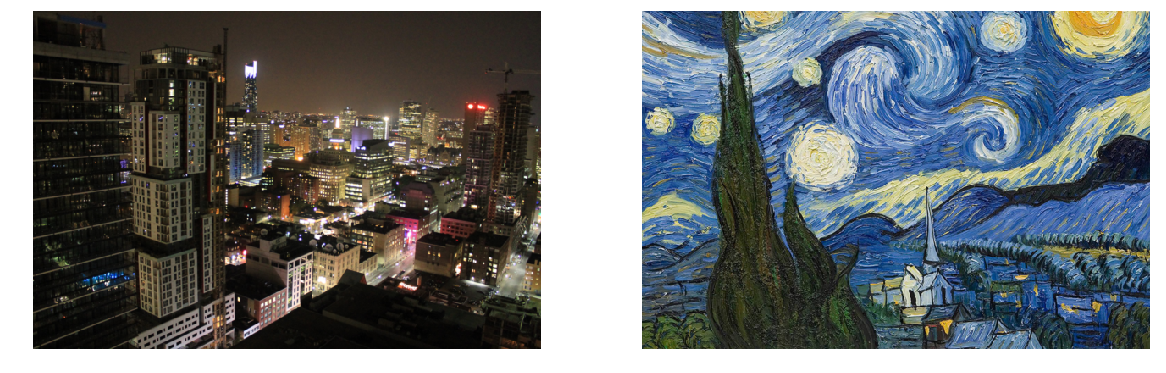

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

## Extracting Features from the Images using CNN's

The following function extracts the ouputs of the CNN at certain layers throughout the neural net to gain feature information about the content and style of an image

In [0]:
def get_features(image, model):
  layers = {
              '0': 'conv1_1',  # this layer is for style extraction
              '5': 'conv2_1',  # this layer is for style extraction
              '10': 'conv3_1', # this layer is for style extraction
              '19': 'conv4_1', # this layer is for style extraction
              '21': 'conv4_2', # this layer is for content extraction
              '28': 'conv5_1'  # this layer is for style extraction
            } 
            # these layers were chosen based on the research paper
  
  features = {}
  
  for name, layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
    
  return features

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
def gram_matrix(tensor): # this function will take a tensor and convert it into a gram matrix (gram matrix is simply a matrix multiplied by its transpose)
  _, img_depth, img_height, img_width = tensor.size()
  tensor = tensor.view(img_depth, img_height*img_width)
  gram = torch.mm(tensor, tensor.t())
  return gram

In the following cell we are converting all of the tensors in the style_features dictionary to gram matrices as this has been proven to help extract the styling information in an image (this was discussed in the paper)

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

## Defining Weights and initializing target image 

The following cell defines a style_weights dictionary that assigns different weights to the layer outputs from the CNN. Since earlier layers are better at extracting style features we assign more weight to these layers than the later layers.

In [0]:
style_weights = {
                  'conv1_1': 1,
                  'conv2_1': 0.75,
                  'conv3_1': 0.2,
                  'conv4_1': 0.2,
                  'conv5_1': 0.2
                 } # notice that conv4_2 is not included in this dictionary since it is only used for content extraction and not style extraction

The following cell defines the weight we will assign to the content vs the weight assigned to the styling. We use these values when combining to create our target image. The higher the weight (or ratio) the more it impacts the target image.

In [0]:
content_weight = 1
style_weight = 1e6

In [0]:
target = content.clone().requires_grad_(True).to(device) # defining the initial target image (before training), which is just a copy of the content image

## Optimization

In [0]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 10000

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels)) # 300 is the max size of the array, this array stores the target image iterations throughout the training process
capture_frame = steps/300
counter = 0

In [0]:
print('Training, please wait...')
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2) # mean squared error formula used for calculating the loss
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, img_depth, img_height, img_width = target_feature.shape
    style_loss += layer_style_loss/ (img_depth*img_height*img_width) # normalizing the layer loss and then adding it to the total style loss
  
  total_loss = content_loss*content_weight + style_loss*style_weight # weighted total loss

  optimizer.zero_grad() # zeros the gradients from the previous step
  total_loss.backward() # calculates the gradient 
  optimizer.step()      # backpropgates the gradient and updates the weights

  if ii % show_every == 0: # how often we print the target image during the training
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis('off')
    plt.show()
  
  if ii % capture_frame == 0: # how often we store the output from the model while it is training for data visualization later
     image_array[counter] = im_convert(target)
     counter += 1

Output hidden; open in https://colab.research.google.com to view.

## Showing the Results

(-0.5, 599.5, 399.5, -0.5)

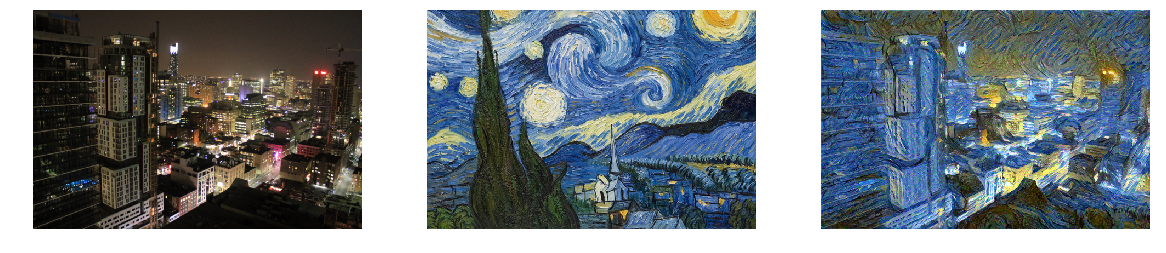

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')